In [1]:
import cv2 
from scipy.ndimage.morphology import binary_erosion, binary_dilation, binary_fill_holes

from spatial_statistics_tools2D import *
from process_images2D import *
from spatial_statistics_tools3D import *
from process_images3D import *
from utilities import *
from pylab import figure, cm
from matplotlib.colors import LogNorm

In [2]:
masks = {
    "cell" : np.load("toy_data_imgs/cell.npy"),
    "circle" : np.load("toy_data_imgs/circle.npy"),
    "square" : np.load("toy_data_imgs/square.npy"),
    "triangle1" : np.load("toy_data_imgs/triangle1.npy"),
    "triangle2" : np.load("toy_data_imgs/triangle2.npy"),
    "triangle3" : np.load("toy_data_imgs/triangle3.npy"),
    "triangle4" : np.load("toy_data_imgs/triangle4.npy"),
}

custom_patterns = {
    "double_cluster" : np.load("toy_data_imgs/clustered.npy"),
    "two_dots" : np.load("toy_data_imgs/two_dots.npy"),
    "disperse" : np.load("toy_data_imgs/dispersed.npy"),
}

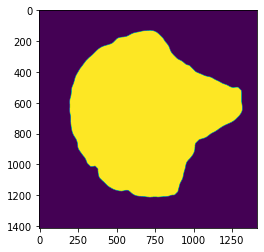

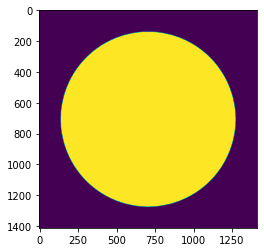

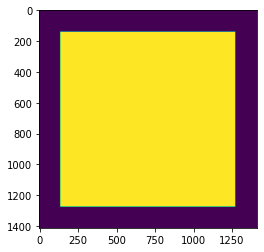

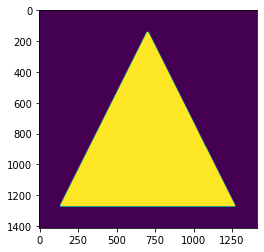

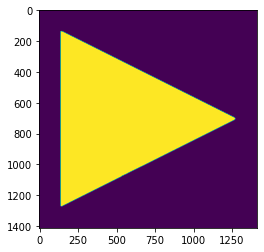

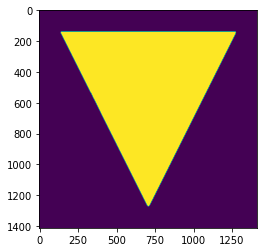

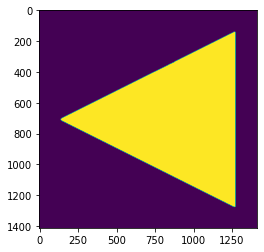

In [3]:
for k in masks.keys():
    plt.imshow(masks[k])
    plt.show()

In [4]:
def truncated_gaussian(mean, sigma, N=1):
    """
    ...
    """
    return np.round(np.random.normal(mean, sigma, N))


def generate_random_cell_image(mask, point_radius=8, pixel_int=10, n_points=1000, n_points_cluster=0, cluster_size=100, cluster_positions=[(0,0)], desired_int=2000000000, binary=False, seed=None):
    """
    ...
    """
    x_lim, y_lim = mask.shape
    arr = np.zeros(mask.shape)
    
    if n_points_cluster > n_points:
        print("Error! Total number of pixels n_points must be larger than or equal to n_points_cluster!")
        return

    n_points_uniform = n_points - n_points_cluster

    # define size of cluster := FWHM = 2.355 * sigma (for Gaussian)
    sigma = cluster_size/2.355
    n_points_cluster = int(n_points_cluster/len(cluster_positions))

    # set seed
    np.random.seed(seed)

    # generate random pixels in the area specified by cell mask
    count=0
    while count<n_points_uniform:
        rnd_x = np.random.randint(x_lim)
        rnd_y = np.random.randint(y_lim)
        if mask[rnd_x, rnd_y] == 1 and arr[rnd_x, rnd_y] == 0:
            arr[rnd_x, rnd_y] = pixel_int #+ arr[rnd_x, rnd_y]
            count+=1

    # generate additional pixels around a defined cluster 
    for cluster_pos in cluster_positions:
        mean_x, mean_y = cluster_pos
        count=0
        while count<n_points_cluster:
            rnd_x = int(truncated_gaussian(mean_x+x_lim/2, sigma))
            rnd_y = int(truncated_gaussian(mean_y+y_lim/2, sigma))
            if (rnd_x < x_lim) and (rnd_y < y_lim):
                if mask[rnd_x, rnd_y] == 1 and arr[rnd_x, rnd_y] == 0:
                    arr[rnd_x, rnd_y] = pixel_int #+ arr[rnd_x, rnd_y]    
                    count+=1

    if np.sum(arr) != pixel_int*n_points:
        print("Error! Amount of points in resulting image is not equal to specified number of points!")
        return

    # slightly dilate and blur the pixels to enlarge them
    arr = binary_dilation(arr, iterations=point_radius-4)
    arr = gaussian(arr, sigma=3)
    
    # if binary, then image will only have values 1 or 0
    if binary:
        img_real = exposure.equalize_hist(img_real)>0.97

    img_csr = scale_image(mask, desired_int) 
    img_real = scale_image(arr, desired_int)
    
    np.random.seed(None)
    
    return img_real, img_csr


def generate_equally_spaced_image(mask, point_radius, pixel_int, spacing, desired_int):
    """
    Within a shape specified by mask, generate equally spaced grid.
    """
    arr = np.zeros(mask.shape)

    for i in range(1, int(arr.shape[0]/spacing)):
        for j in range(1, int(arr.shape[1]/spacing)):
            x = i*spacing
            y = j*spacing + int(spacing/2 * (i%2))

            if mask[x,y] == 1:
                arr[x,y] = 10

    arr = binary_dilation(arr, iterations=point_radius-4)
    arr = gaussian(arr, sigma=3)
    
    img_real = scale_image(arr, desired_int)
    img_csr = scale_image(mask, desired_int)

    return img_real, img_csr


def get_K_data(mask, img_real, img_csr, range_of_t, width, printout=True):
    """
    ...
    """
    K_values_real, K_values_ring_real, corr_real = ripleys_K_fast_ring(img_real, mask, range_of_t, width, printout)
    K_values_csr, K_values_ring_csr, corr_csr = ripleys_K_fast_ring(img_csr, mask, range_of_t, width, printout)    
    data_real = [np.array(K_values_real), np.array(K_values_ring_real), corr_real, range_of_t]
    data_csr = [np.array(K_values_csr), np.array(K_values_ring_csr), corr_csr, range_of_t]
    
    return data_real, data_csr

In [23]:
def plot_results1(data_real, data_csr, width, title="", path="./unnamed.pdf", show=False, save=True):
    
    
    K_values_real, K_values_ring_real, corr_real, range_of_t = data_real
    K_values_csr, K_values_ring_csr, corr_csr, range_of_t = data_csr
    
    K_diff = K_values_real - K_values_csr
    K_ring_diff = K_values_ring_real - K_values_ring_csr


    # works only if number odd, but this should be given for autocorrelation
    len_ = corr_real.shape[0]
    lim_lower = -int(len_/2)
    lim_upper = int(len_/2)

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    ax[0][0].imshow(img_real)
    im1 = ax[0][0].imshow(img_real)
    ax[0][0].set_title("Original (\"real\") image")
    ax[0][1].set_title("(autocorr. real) - (autocor. CSR); negative values in white")
    im2 = ax[0][1].matshow((corr_real-corr_csr), norm=LogNorm(), extent=[lim_lower, lim_upper, lim_lower, lim_upper])    
    ax[1][0].set_title("Autocorr. real image")

    ax[1][0].set_title("K function for (real)-(CSR)")
    ax[1][0].plot(range_of_t, K_diff)
    ax[1][0].set_xlabel("$t$")
    ax[1][0].set_ylabel("$K(t)$")

    ax[1][1].set_title(f"Ring K function for (real)-(CSR), width={width}")
    ax[1][1].plot(range_of_t + int(width/2), K_ring_diff)
    ax[1][1].set_xlabel("$t$")
    ax[1][1].set_ylabel("$K_{Ring}(t)$")

    plt.colorbar(im1, ax=ax[0, 0])
    plt.colorbar(im2, ax=ax[0, 1])

    fig.suptitle(title)
    if save:
        plt.savefig(path)
    if show:
        plt.show()
    plt.close()
    
    
    
def plot_results2(data_real, data_csr, width, title="", path="./unnamed.pdf", show=False, save=True):

    
    K_values_real, K_values_ring_real, corr_real, range_of_t = data_real
    K_values_csr, K_values_ring_csr, corr_csr, range_of_t = data_csr

    K_diff = K_values_real - K_values_csr
    K_ring_diff = K_values_ring_real - K_values_ring_csr

    # works only if number odd, but this should be given for autocorrelation
    len_ = corr_real.shape[0]
    lim_lower = -int(len_/2)
    lim_upper = int(len_/2)

    fig, ax = plt.subplots(1, 4, figsize=(30, 6))

    ax[0].imshow(img_real)
    im1 = ax[0].imshow(img_real)
    ax[0].set_title("Original (\"real\") image")
    ax[1].set_title("(autocorr. real) - (autocor. CSR); negative values in white")
    im2 = ax[1].matshow((corr_real-corr_csr), norm=LogNorm(), extent=[lim_lower, lim_upper, lim_lower, lim_upper])    

    ax[2].set_title(f"Ring K functions for real and CSR image")
    ax[2].plot(range_of_t + int(width/2), K_values_ring_real, label="Real image")
    ax[2].plot(range_of_t + int(width/2), K_values_ring_csr, label="CSR image")
    ax[2].plot(range_of_t + int(width/2), K_ring_diff, label="Difference")
    ax[2].legend(loc='upper right')
    ax[2].set_xlabel("$t$")
    ax[2].set_ylabel("$Autocorr$")

    ax[3].set_title(f"Ring K function for (real)-(CSR), width={width}")
    ax[3].plot(range_of_t + int(width/2), K_ring_diff)
    ax[3].set_xlabel("$t$")
    ax[3].set_ylabel("$K_{Ring}(t)$")

    plt.colorbar(im1, ax=ax[0])
    plt.colorbar(im2, ax=ax[1])

    fig.suptitle(title)
    if save:
        plt.savefig(path)
    if show:
        plt.show()
    plt.close()

## Experimenting with different toy datasets of generated cell images

Creating ...


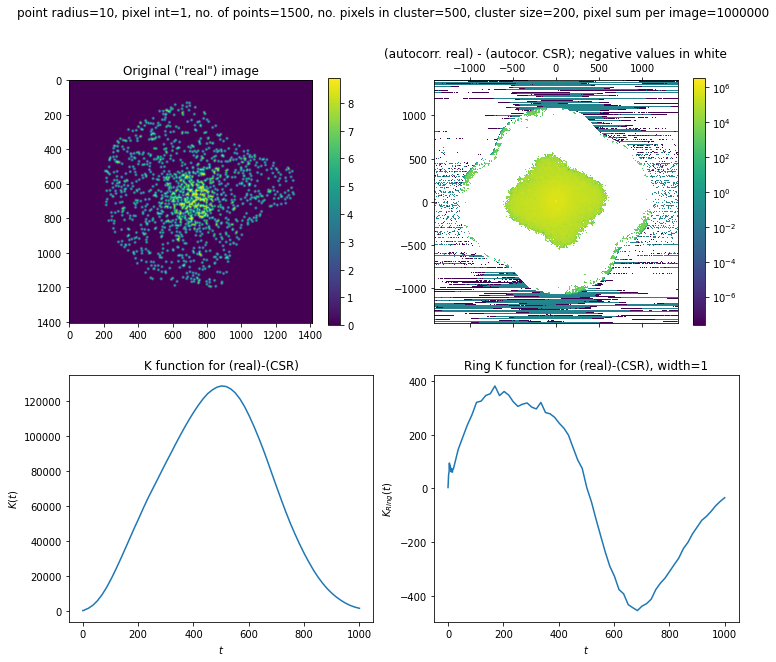

Completed!


In [24]:
#------------------
# Setup parameters
#------------------

# for K-function
width=1
point_radius=10
pixel_int=1
n_points=1500
# in case of equally-spaced grid
spacing=40
n_points_cluster=500
cluster_size=200
#cluster_positions=[(250,0),(-250,0),(0,200),(0,-200)]
cluster_positions = [(0,0)]
desired_int=1000000
binary=False
rnd_overlay = 0
true_csr = False

show = True
save = False

custom_pattern_name = "double_cluster"
mask_name = "cell"
mode = "normal"

seed=65493

# t-values as inputs for the K-function
range_of_t = np.array(list(range(20)) + list(np.linspace(20, 1000, 60)))


custom_pattern = custom_patterns[custom_pattern_name]
mask = masks[mask_name]
csr_name = "true_random_csr" if true_csr else "averaged_csr"


# save results
folder = "toy_data_results"
filename = ""
path = os.path.join(folder, filename)
print(f"Creating {filename}...")


if mode=='equally_spaced':
    title = f"point radius={point_radius}, pixel int={pixel_int}, grid spacing={spacing}, pixel sum per image={desired_int}"
    img_real, img_csr = generate_equally_spaced_image(mask, point_radius, pixel_int, spacing, desired_int)
elif mode=='custom':
    title = f"{custom_pattern_name.replace('_', '')}, pixel sum per image={desired_int}"
    rnd_points = generate_random_cell_image(mask, point_radius, pixel_int, n_points, n_points_cluster=0, cluster_size=0, cluster_positions=[(0,0)], desired_int=desired_int, binary=False, seed=seed)[0] 
    custom_pattern = scale_image(custom_pattern, desired_int)
    img_real = scale_image(custom_pattern + rnd_overlay*rnd_points, desired_int)
    img_csr = scale_image(mask, desired_int)
else:
    title = f"point radius={point_radius}, pixel int={pixel_int}, no. of points={n_points}, no. pixels in cluster={n_points_cluster}, cluster size={cluster_size}, pixel sum per image={desired_int}"
    img_real, img_csr = generate_random_cell_image(mask, point_radius, pixel_int, n_points, n_points_cluster, cluster_size, cluster_positions, desired_int, False, seed) 


# generate CSR with actual uniformely random pixel distribution
if true_csr:
    img_csr = create_csr_img(mask, desired_int)

data_real, data_csr = get_K_data(mask, img_real, img_csr, range_of_t, width, True)

plot_results1(data_real, data_csr, width, title, path, show, save)

        
print("Completed!")

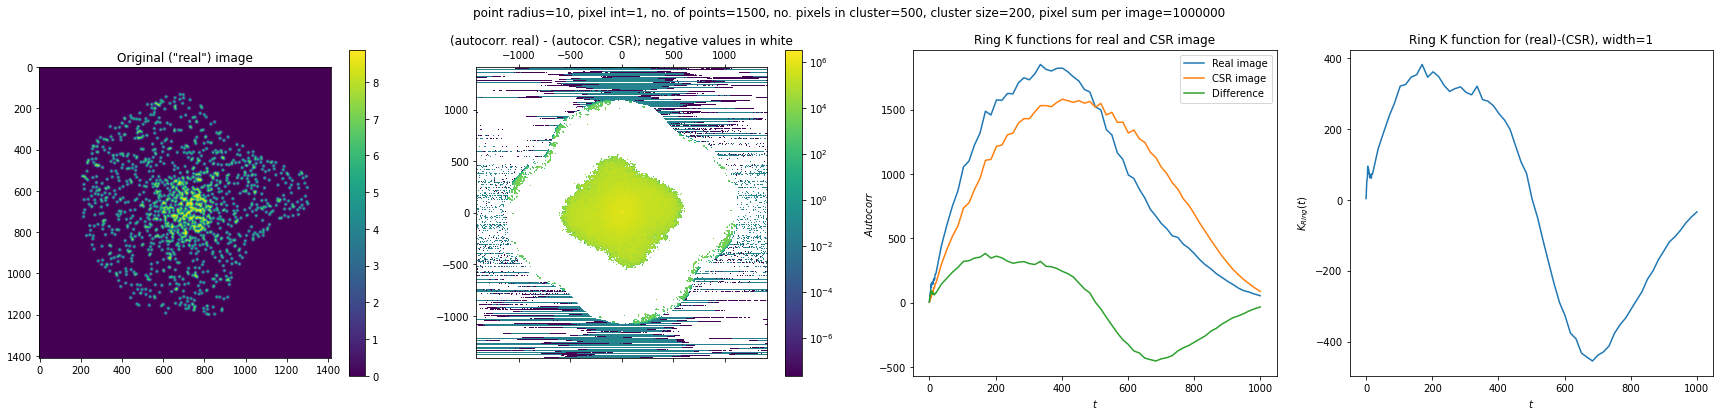

In [26]:
# different way of plotting the results
plot_results2(data_real, data_csr, width, title, path, True, False)

### Some other tests with the K-function and autocorrelation

In [52]:
img = custom_patterns["double_cluster"]

mask = masks["circle"]

img = scale_image(img, 1000000)
csr = scale_image(mask, 1000000)

corr_real = signal.correlate(img, img)

range_of_t = np.linspace(5, 600, 60)
Ks = ripleys_K_fast(img, mask, range_of_t, True)


# works only if number odd, but this should be given for autocorrelation
len_ = corr_real.shape[0]
lim_lower = -int(len_/2)
lim_upper = int(len_/2)


Completed in 4.17 seconds


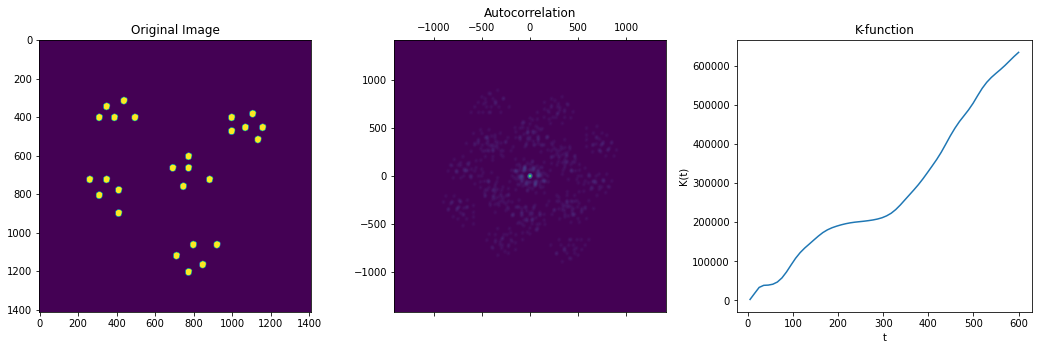

In [53]:
fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[1].matshow((corr_real), extent=[lim_lower, lim_upper, lim_lower, lim_upper])  
ax[1].set_title("Autocorrelation")
ax[2].plot(range_of_t, Ks)
ax[2].set_ylabel("K(t)")
ax[2].set_xlabel("t")
ax[2].set_title("K-function")
plt.savefig("K_function_example.pdf")